   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue           NaN            NYC    NY   
1             59 rue de l'Abbaye           NaN

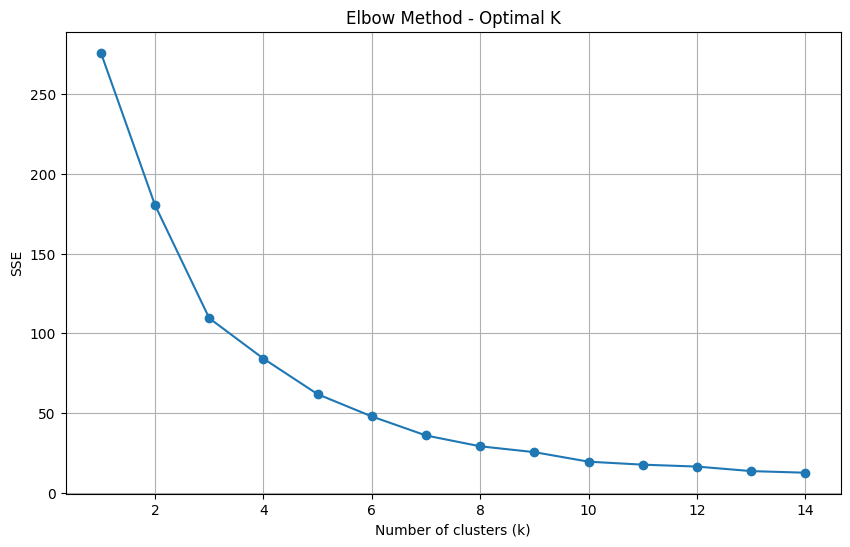


Clustered RFM Data:
                          Recency  Frequency  MonetaryValue  R  F  M  \
CUSTOMERNAME                                                          
AV Stores, Co.               196         51      157807.81  2  4  4   
Alpha Cognac                  65         20       70488.44  4  2  2   
Amica Models & Co.           265         26       94117.26  1  2  3   
Anna's Decorations, Ltd       84         46      153996.13  3  4  4   
Atelier graphique            188          7       24179.96  2  1  1   

                         RFM_Score            RFM_Level  Cluster  
CUSTOMERNAME                                                      
AV Stores, Co.                  10  High Value Customer        3  
Alpha Cognac                     8   Mid Value Customer        4  
Amica Models & Co.               6   Mid Value Customer        4  
Anna's Decorations, Ltd         11  High Value Customer        3  
Atelier graphique                4   Low Value Customer        2  


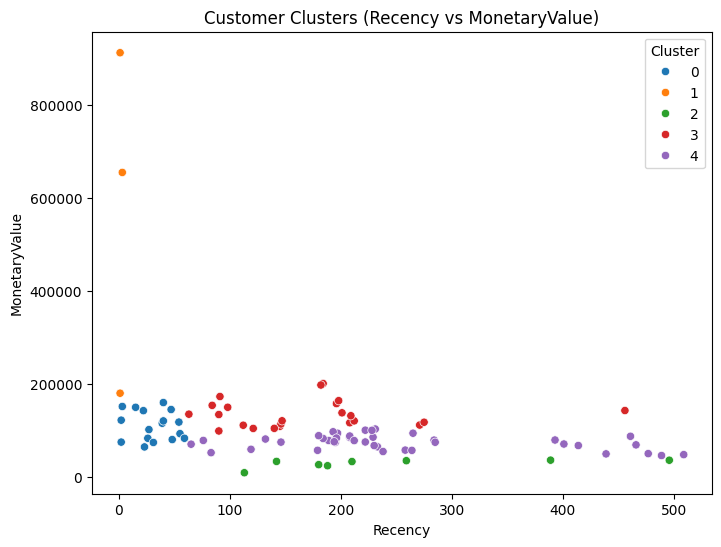

In [2]:
# ```python
# ----------------------------------
# Practical 5: Sales Data Clustering with RFM Analysis
# ----------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("sales_data_sample.csv", encoding="unicode_escape")
print(df.head())
print(df.info())

# -----------------------------
# Drop unnecessary columns
# -----------------------------
to_drop = [
    "ADDRESSLINE1", "ADDRESSLINE2", "POSTALCODE", "CITY",
    "TERRITORY", "PHONE", "STATE", "CONTACTFIRSTNAME",
    "CONTACTLASTNAME"
]
df = df.drop(to_drop, axis=1, errors="ignore")
print("\nColumns after dropping:\n", df.columns)

# -----------------------------
# Convert ORDERDATE to datetime
# -----------------------------
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")

# -----------------------------
# RFM Feature Calculation
# -----------------------------
snapshot_date = df["ORDERDATE"].max() + dt.timedelta(days=1)

df_RFM = df.groupby("CUSTOMERNAME").agg({
    "ORDERDATE": lambda x: (snapshot_date - x.max()).days,
    "ORDERNUMBER": "count",
    "SALES": "sum"
})

df_RFM.rename(columns={
    "ORDERDATE": "Recency",
    "ORDERNUMBER": "Frequency",
    "SALES": "MonetaryValue"
}, inplace=True)

# -----------------------------
# Quartile segmentation
# -----------------------------
df_RFM["R"] = pd.qcut(df_RFM["Recency"], q=4, labels=[4, 3, 2, 1])
df_RFM["F"] = pd.qcut(df_RFM["Frequency"], q=4, labels=[1, 2, 3, 4])
df_RFM["M"] = pd.qcut(df_RFM["MonetaryValue"], q=4, labels=[1, 2, 3, 4])

df_RFM["RFM_Score"] = df_RFM[["R", "F", "M"]].astype(int).sum(axis=1)

def rfm_level(row):
    if row["RFM_Score"] >= 10:
        return "High Value Customer"
    elif 6 <= row["RFM_Score"] < 10:
        return "Mid Value Customer"
    else:
        return "Low Value Customer"

df_RFM["RFM_Level"] = df_RFM.apply(rfm_level, axis=1)
print("\nSample RFM Table:\n", df_RFM.head())

# -----------------------------
# Prepare data for clustering
# -----------------------------
data = df_RFM[["Recency", "Frequency", "MonetaryValue"]]

# Log transformation (reduce skewness)
data_log = np.log1p(data)

# Standardization
scaler = StandardScaler()
data_normalized = pd.DataFrame(
    scaler.fit_transform(data_log),
    index=data_log.index,
    columns=data_log.columns
)

print("\nNormalized Data Summary:\n", data_normalized.describe().round(2))

# -----------------------------
# KMeans Clustering (Elbow Method)
# -----------------------------
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker="o")
plt.title("Elbow Method - Optimal K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.grid(True)
plt.show()

# -----------------------------
# Final KMeans Model (e.g., K=5)
# -----------------------------
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(data_normalized)

df_RFM["Cluster"] = cluster_labels
print("\nClustered RFM Data:\n", df_RFM.head())

# -----------------------------
# Cluster Visualization
# -----------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="Recency", y="MonetaryValue", hue="Cluster",
    data=df_RFM, palette="tab10"
)
plt.title("Customer Clusters (Recency vs MonetaryValue)")
plt.show()
# ```
